In [ ]:
% pip install optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_column', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
import scipy.stats as stats
import pylab

from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

import sklearn
# import optuna
import xgboost as xgb

In [ ]:
def my_print(s):
    '''Custom print function by @kartik2khandelwal :)'''
    a = 4
    for i in s:
        a+=1
    return print('-' * a + '\n' + '| ' + s + ' |' + '\n' + '-' * a)

In [ ]:
def iterative_imputer(df):
    my_print(f'Null Values - {df.isnull().sum().sum()}')
    my_print('Applying Iterative Imputer...')
    imputer = IterativeImputer(max_iter=10)
    data = imputer.fit_transform(df)
    df = pd.DataFrame(data, columns=list(df.columns))
    my_print('Iterative Imputer Applied !!!')
    my_print(f'Null Values Left - {df.isnull().sum().sum()}')    
    return df

def outlier_viz(col):
    import random
    color = random.choice(['r', 'g', 'b'])
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    sns.distplot(col, ax=ax[0], color=color)
    sns.boxplot(col, ax=ax[1], color=color)
    plt.suptitle('Distribution & Boxplot for Outlier Detection')
    fig.show()
    return None

In [ ]:
train=pd.read_csv('train_dataset.csv')
X_test=pd.read_csv('test_dataset.csv')
train.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7135,1654,CL,D-penicillamine,19581,F,N,N,Y,N,0.3,279.0,2.96,84.0,1500.8,99.43,109.0,293.0,10.2,4.0
1,7326,41,C,D-penicillamine,22880,F,NaN,N,NaN,N,0.3,NaN,2.96,NaN,1835.4,26.35,131.0,308.0,10.8,1.0
2,7254,297,D,NaN,27957,F,N,N,NaN,N,0.3,328.0,2.64,4.0,NaN,NaN,116.0,194.0,10.3,3.0
3,3135,1872,C,D-penicillamine,21111,F,NaN,Y,Y,N,0.3,302.0,2.02,49.0,NaN,26.35,NaN,NaN,10.5,4.0
4,2483,939,CL,D-penicillamine,18061,F,NaN,NaN,NaN,N,0.5,344.0,3.11,91.0,NaN,104.56,NaN,306.0,11.4,2.0


In [ ]:
df=train.drop('ID',axis=1)
dt=X_test.drop('ID',axis=1)

In [ ]:
df.isnull().sum()

N_Days              0
Status              0
Drug             2025
Age                 0
Sex                 0
Ascites          2246
Hepatomegaly     2427
Spiders          2590
Edema               0
Bilirubin           0
Cholesterol      3101
Albumin             0
Copper           2156
Alk_Phos         2498
SGOT             2102
Tryglicerides    2812
Platelets         338
Prothrombin       155
Stage               0
dtype: int64

In [ ]:
cat = [i for i in df.columns if len(df[i].unique()) < 4]
num = [i for i in df.drop(['Stage'], axis=1).columns if len(df[i].unique()) > 4]

In [ ]:
def new_col(df):
    df['Bilirubin_cat']  = df['Bilirubin'].apply(lambda x:0 if x < 5 else 1)
    df['Cholesterol']    = df['Cholesterol'].apply(lambda x:df['Cholesterol'].mean() if x > 840 else x)
    df['Copper']         = df['Copper'].apply(lambda x:df['Copper'].mean() if x > 300 else x)
    df['Alk_Phos_cat']   = df['Alk_Phos'].apply(lambda x:1 if x > 4000 else 0)
    df['Alk_Phos']       = df['Alk_Phos'].apply(lambda x:df['Alk_Phos'].mean() if x > 9200 else x)
    df['SGOT']           = df['SGOT'].apply(lambda x:df['SGOT'].mean() if x > 300 else x)
    df['Tryglicerides']  = df['Tryglicerides'].apply(lambda x:df['Tryglicerides'].mean() if x>300 else x)
    df['Prothrombin']    = df['Prothrombin'].apply(lambda x:df['Prothrombin'].mean() if x>16 else x)
    return df

In [ ]:
df = new_col(df)
cat.extend(['Alk_Phos_cat','Bilirubin_cat'])
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Bilirubin_cat,Alk_Phos_cat
0,1654,CL,D-penicillamine,19581,F,N,N,Y,N,0.3,279.0,2.96,84.0,1500.8,99.43,109.0,293.0,10.2,4.0,0,0
1,41,C,D-penicillamine,22880,F,NaN,N,NaN,N,0.3,NaN,2.96,NaN,1835.4,26.35,131.0,308.0,10.8,1.0,0,0
2,297,D,NaN,27957,F,N,N,NaN,N,0.3,328.0,2.64,4.0,NaN,NaN,116.0,194.0,10.3,3.0,0,0
3,1872,C,D-penicillamine,21111,F,NaN,Y,Y,N,0.3,302.0,2.02,49.0,NaN,26.35,NaN,NaN,10.5,4.0,0,0
4,939,CL,D-penicillamine,18061,F,NaN,NaN,NaN,N,0.5,344.0,3.11,91.0,NaN,104.56,NaN,306.0,11.4,2.0,0,0


In [ ]:
df[num] = iterative_imputer(df[num])

-----------------------
| Null Values - 13162 |
-----------------------
---------------------------------
| Applying Iterative Imputer... |
---------------------------------
---------------------------------
| Iterative Imputer Applied !!! |
---------------------------------
------------------------
| Null Values Left - 0 |
------------------------


In [ ]:
df[cat].isnull().sum()

Status              0
Drug             2025
Sex                 0
Ascites          2246
Hepatomegaly     2427
Spiders          2590
Edema               0
Alk_Phos_cat        0
Bilirubin_cat       0
dtype: int64

In [ ]:
df.fillna('None', axis=1, inplace=True)

In [ ]:
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Bilirubin_cat,Alk_Phos_cat
0,1654.0,CL,D-penicillamine,19581.0,F,N,N,Y,N,0.3,279.000000,2.96,84.00000,1500.800000,99.430000,109.000000,293.000000,10.2,4.0,0,0
1,41.0,C,D-penicillamine,22880.0,F,None,N,None,N,0.3,282.895967,2.96,65.06031,1835.400000,26.350000,131.000000,308.000000,10.8,1.0,0,0
2,297.0,D,None,27957.0,F,N,N,None,N,0.3,328.000000,2.64,4.00000,1670.964888,80.526342,116.000000,194.000000,10.3,3.0,0,0
3,1872.0,C,D-penicillamine,21111.0,F,None,Y,Y,N,0.3,302.000000,2.02,49.00000,1593.895339,26.350000,133.343483,282.580481,10.5,4.0,0,0
4,939.0,CL,D-penicillamine,18061.0,F,None,None,None,N,0.5,344.000000,3.11,91.00000,1705.265427,104.560000,128.508405,306.000000,11.4,2.0,0,0


In [ ]:
df['Stage'] = df['Stage'].astype('int32')


In [ ]:
X_test = new_col(X_test)
X_test[num] = iterative_imputer(X_test[num])
X_test.fillna('None', axis=1, inplace=True)

----------------------
| Null Values - 6110 |
----------------------
---------------------------------
| Applying Iterative Imputer... |
---------------------------------
---------------------------------
| Iterative Imputer Applied !!! |
---------------------------------
------------------------
| Null Values Left - 0 |
------------------------


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for i in cat:
    df[i] = label.fit_transform(df[i])
    X_test[i] = label.fit_transform(X_test[i])

In [ ]:
for i in range(3):
    sm = SMOTE(sampling_strategy='minority', random_state=42)
    oversampled_X, oversampled_Y = sm.fit_resample(df.drop(['Stage'], axis=1), df['Stage'])
    df = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [ ]:
df.shape

(14024, 21)

In [ ]:
X = df.drop(['Stage'], axis=1)
y = df['Stage']

In [ ]:
test_data = X_test.drop('ID', axis=1)

In [ ]:
test_data.shape, X.shape

((3200, 20), (14024, 20))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True)

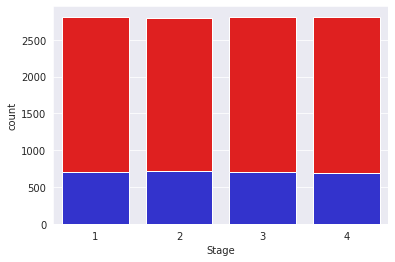

In [ ]:
sns.countplot(y_train, color='r') 
sns.countplot(y_valid, color='b', saturation=0.6);

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid  = xgb.DMatrix(X_valid, label=y_valid)

def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "tree_method":'gpu_hist',
        "gpu_id" : 0,
        "num_class": 5,
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'n_estimators': 5,
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20)
    }

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_valid, pred_labels)
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5000)

Streaming output truncated to the last 5000 lines.
[W 2022-02-25 11:26:55,347] Trial 0 failed, because the value None could not be cast to float.
[W 2022-02-25 11:26:55,352] Trial 1 failed, because the value None could not be cast to float.
[W 2022-02-25 11:26:55,356] Trial 2 failed, because the value None could not be cast to float.
[W 2022-02-25 11:26:55,359] Trial 3 failed, because the value None could not be cast to float.
[W 2022-02-25 11:26:55,361] Trial 4 failed, because the value None could not be cast to float.
[W 2022-02-25 11:26:55,364] Trial 5 failed, because the value None could not be cast to float.
[W 2022-02-25 11:26:55,366] Trial 6 failed, because the value None could not be cast to float.
[W 2022-02-25 11:26:55,368] Trial 7 failed, because the value None could not be cast to float.
[W 2022-02-25 11:26:55,370] Trial 8 failed, because the value None could not be cast to float.
[W 2022-02-25 11:26:55,372] Trial 9 failed, because the value None could not be cast to float.

In [ ]:
new_param = study.best_params
new_param

ValueError: ignored

In [ ]:
model = xgb.XGBClassifier(
#                              tree_method='gpu_hist', 
#                              gpu_id=0, 
#                              predictor="gpu_predictor", 
                             **new_param, #eval_set=[(X_valid,y_valid)]
                          )

model.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob', x=-99.99992596913356)

In [ ]:
my_print(f'Training Accuracy   :- {(model.score(X_train, y_train)*100).round(2)}%')
my_print(f'Validation Accuracy :- {(model.score(X_valid, y_valid)*100).round(2)}%')

---------------------------------
| Training Accuracy   :- 51.47% |
---------------------------------
---------------------------------
| Validation Accuracy :- 45.49% |
---------------------------------


In [ ]:
X_test.isnull().sum()

ID               0
N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Bilirubin_cat    0
Alk_Phos_cat     0
dtype: int64

In [ ]:
cat = [i for i in dt.columns if len(dt[i].unique()) < 4]
# num = [i for i in dt.drop(['Stage'], axis=1).columns if len(dt[i].unique()) > 4]

In [ ]:
def new_col(dt):
    dt['Bilirubin_cat']  = dt['Bilirubin'].apply(lambda x:0 if x < 5 else 1)
    dt['Cholesterol']    = dt['Cholesterol'].apply(lambda x:df['Cholesterol'].mean() if x > 840 else x)
    dt['Copper']         = dt['Copper'].apply(lambda x:df['Copper'].mean() if x > 300 else x)
    dt['Alk_Phos_cat']   = dt['Alk_Phos'].apply(lambda x:1 if x > 4000 else 0)
    dt['Alk_Phos']       = dt['Alk_Phos'].apply(lambda x:df['Alk_Phos'].mean() if x > 9200 else x)
    dt['SGOT']           = dt['SGOT'].apply(lambda x:df['SGOT'].mean() if x > 300 else x)
    dt['Tryglicerides']  = dt['Tryglicerides'].apply(lambda x:df['Tryglicerides'].mean() if x>300 else x)
    dt['Prothrombin']    = dt['Prothrombin'].apply(lambda x:df['Prothrombin'].mean() if x>16 else x)
    return dt

In [ ]:
dt = new_col(df)
cat.extend(['Alk_Phos_cat','Bilirubin_cat'])
dt.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Bilirubin_cat,Alk_Phos_cat
0,1654,CL,D-penicillamine,19581,F,N,N,Y,N,0.3,279.0,2.96,84.0,1500.8,99.43,109.0,293.0,10.2,4.0,0,0
1,41,C,D-penicillamine,22880,F,NaN,N,NaN,N,0.3,NaN,2.96,NaN,1835.4,26.35,131.0,308.0,10.8,1.0,0,0
2,297,D,NaN,27957,F,N,N,NaN,N,0.3,328.0,2.64,4.0,NaN,NaN,116.0,194.0,10.3,3.0,0,0
3,1872,C,D-penicillamine,21111,F,NaN,Y,Y,N,0.3,302.0,2.02,49.0,NaN,26.35,NaN,NaN,10.5,4.0,0,0
4,939,CL,D-penicillamine,18061,F,NaN,NaN,NaN,N,0.5,344.0,3.11,91.0,NaN,104.56,NaN,306.0,11.4,2.0,0,0


In [ ]:
dt[num] = iterative_imputer(dt[num])

-----------------------
| Null Values - 13162 |
-----------------------
---------------------------------
| Applying Iterative Imputer... |
---------------------------------
---------------------------------
| Iterative Imputer Applied !!! |
---------------------------------
------------------------
| Null Values Left - 0 |
------------------------


In [ ]:
dt.fillna('None', axis=1, inplace=True)

In [ ]:
dt

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Bilirubin_cat,Alk_Phos_cat
0,1654.0,CL,D-penicillamine,19581.0,F,N,N,Y,N,0.3,279.000000,2.96,84.000000,1500.800000,99.430000,109.000000,293.000000,10.2,4.0,0,0
1,41.0,C,D-penicillamine,22880.0,F,None,N,None,N,0.3,282.895967,2.96,65.060310,1835.400000,26.350000,131.000000,308.000000,10.8,1.0,0,0
2,297.0,D,None,27957.0,F,N,N,None,N,0.3,328.000000,2.64,4.000000,1670.964888,80.526342,116.000000,194.000000,10.3,3.0,0,0
3,1872.0,C,D-penicillamine,21111.0,F,None,Y,Y,N,0.3,302.000000,2.02,49.000000,1593.895339,26.350000,133.343483,282.580481,10.5,4.0,0,0
4,939.0,CL,D-penicillamine,18061.0,F,None,None,None,N,0.5,344.000000,3.11,91.000000,1705.265427,104.560000,128.508405,306.000000,11.4,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6795,1762.0,C,Placebo,20909.0,M,None,N,None,N,0.9,360.000000,2.43,65.527073,3444.400000,131.590000,130.000000,314.000000,12.9,1.0,0,0
6796,2955.0,C,Placebo,28650.0,F,Y,N,N,N,0.3,287.778881,2.99,43.000000,1459.779886,81.272873,238.000000,399.000000,10.6,4.0,0,0
6797,584.0,C,None,24102.0,F,N,Y,None,N,0.3,218.000000,2.79,64.842932,1581.066887,26.350000,123.000000,103.000000,9.3,1.0,0,0
6798,1426.0,CL,D-penicillamine,19791.0,F,N,None,Y,N,0.3,296.891248,1.96,12.000000,289.000000,72.950000,134.000000,354.000000,10.6,2.0,0,0


In [ ]:
test_data

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Bilirubin_cat,Alk_Phos_cat
0,41.0,0,2,22553.0,0,0,1,0,0,1.4,247.000000,3.62,64.343685,1624.458198,108.650000,127.995222,169.000000,11.6,0,0
1,1811.0,0,0,16223.0,0,0,2,0,0,0.3,311.000000,2.80,92.000000,1748.100000,80.301160,129.000000,321.000000,11.5,0,0
2,954.0,0,0,27100.0,0,0,0,0,0,0.4,278.296589,3.56,61.075292,1646.676430,43.520000,131.923803,296.000000,10.3,0,0
3,1969.0,2,2,17039.0,0,0,2,0,0,1.2,292.652708,3.16,71.645881,617.100000,113.760000,135.706312,125.000000,10.9,0,0
4,2721.0,2,0,17738.0,0,1,1,1,0,3.2,295.505619,2.36,89.000000,1782.400000,79.461278,129.000000,138.000000,10.6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,4513.0,2,2,18293.0,1,1,0,0,1,0.3,301.338301,2.75,70.353081,2063.900000,111.680000,140.201529,563.000000,10.9,0,0
3196,3281.0,2,1,12149.0,0,0,0,2,0,4.7,422.000000,4.30,106.000000,1203.200000,32.490000,166.000000,261.951919,10.2,0,0
3197,1933.0,2,0,17084.0,0,1,2,1,0,0.8,408.000000,3.56,9.000000,2358.100000,124.700000,131.000000,234.000000,11.6,0,0
3198,2350.0,2,2,28650.0,1,1,1,0,2,15.3,258.000000,3.21,32.000000,1472.700000,113.240000,130.000000,110.000000,10.3,1,0


In [ ]:
target=model.predict(test_data)

In [ ]:
res=pd.DataFrame(target)
res.columns=["Stage"]
res

,Stage
0,2
1,4
2,3
3,3
4,1
...,...
3195,4
3196,3
3197,2
3198,4


In [ ]:
from google.colab import files
res.to_csv('prediction_results.csv')
files.download('prediction_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def objective(trial):

    param = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "tree_method":'gpu_hist',
        "objective": "multi:softmax",
        "num_class": 5,
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'n_estimators': 5,
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 100e-6, 0.9, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 100e-6, 0.01, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.7),
        'min_child_weight': trial.suggest_int('min_child_weight', 15, 25)
    }
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_valid, pred_labels)
    return accuracy

In [ ]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(objective, n_trials=500)

[I 2022-02-25 10:41:39,096] A new study created in memory with name: no-name-af68d8bc-1378-4eb5-be48-9252e50b922d
[W 2022-02-25 10:41:39,141] Trial 0 failed because of the following error: XGBoostError('[10:41:39] /workspace/src/tree/updater_gpu_hist.cu:1407: Exception in gpu_hist: NCCL failure :unhandled cuda error /workspace/src/tree/../common/device_helpers.cuh(896)\n\nStack trace:\n  [bt] (0) /usr/local/lib/python3.7/dist-packages/xgboost/./lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x24) [0x7fc304cf1cb4]\n  [bt] (1) /usr/local/lib/python3.7/dist-packages/xgboost/./lib/libxgboost.so(xgboost::tree::GPUHistMakerSpecialised<xgboost::detail::GradientPairInternal<double> >::Update(xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*, xgboost::DMatrix*, std::vector<xgboost::RegTree*, std::allocator<xgboost::RegTree*> > const&)+0x1270) [0x7fc304f2d7f0]\n  [bt] (2) /usr/local/lib/python3.7/dist-packages/xgboost/./lib/libxgboost.so(xgboost::gbm::GBTree:

XGBoostError: ignored

In [ ]:
new_param2 = study2.best_params
print(new_param2)
model2 = xgb.XGBClassifier(**new_param2)

model2.fit(X_train, y_train)

ValueError: ignored

In [ ]:
model2.predict(new_test)

NameError: ignored